**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

# Brain Tumor Detection Using a Convolutional Neural Network

## Import Necessary Modules

In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imutils

  Using cached imutils-0.5.4.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25855 sha256=53ef5fa9ae922daa3a86cb7097363f20fe33c69f91263fc4a8ae936ff3612874
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\31\d0\2c\87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from os import listdir
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [4]:
def crop_brain_contour(image, plot=False):    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

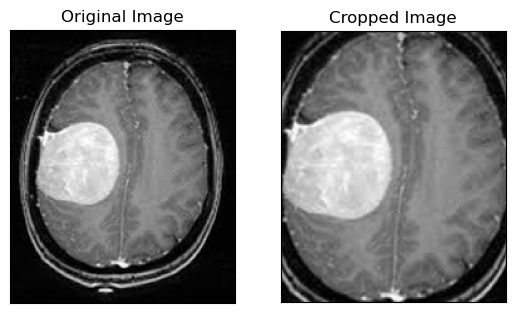

In [7]:
ex_img = cv2.imread(r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master\yes\Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [8]:
ex_img = cv2.imread(r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master\yesY1.jpg')
print(ex_img)

None


### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [13]:
import cv2
from os import listdir
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    """
    Read images, resize, and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple representing the desired image dimensions (width, height).
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            
            # normalize values
            image = image / 255.
            
            # convert image to numpy array and append it to X
            X.append(image)
            
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory.endswith('yes'):
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

# Example usage
dataset_path = r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master'
dir_list = [os.path.join(dataset_path, 'yes'), os.path.join(dataset_path, 'no')]
image_size = (240, 240)

X, y = load_data(dir_list, image_size)


Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [16]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [17]:
# Example usage
dataset_path = r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master'
dir_list = [os.path.join(dataset_path, 'yes'), os.path.join(dataset_path, 'no')]
image_size = (240, 240)

X, y = load_data(dir_list, image_size)

# Print a newline for clarity
print()

# Augmented data path
brain_tumour_dataset_path  =  r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master'

# Corrected paths with a backslash
augmented_yes = os.path.join(brain_tumour_dataset_path, 'yes') 
augmented_no = os.path.join(brain_tumour_dataset_path, 'no')

# Print the paths for debugging
print(f'Augmented Yes Path: {augmented_yes}')
print(f'Augmented No Path: {augmented_no}')

# Try loading augmented data
try:
    X_augmented, y_augmented = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
except FileNotFoundError as e:
    print(f'Error: {e}')



Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)

Augmented Yes Path: C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master\yes
Augmented No Path: C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\Brain-Tumor-Detection-master\no
Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [18]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

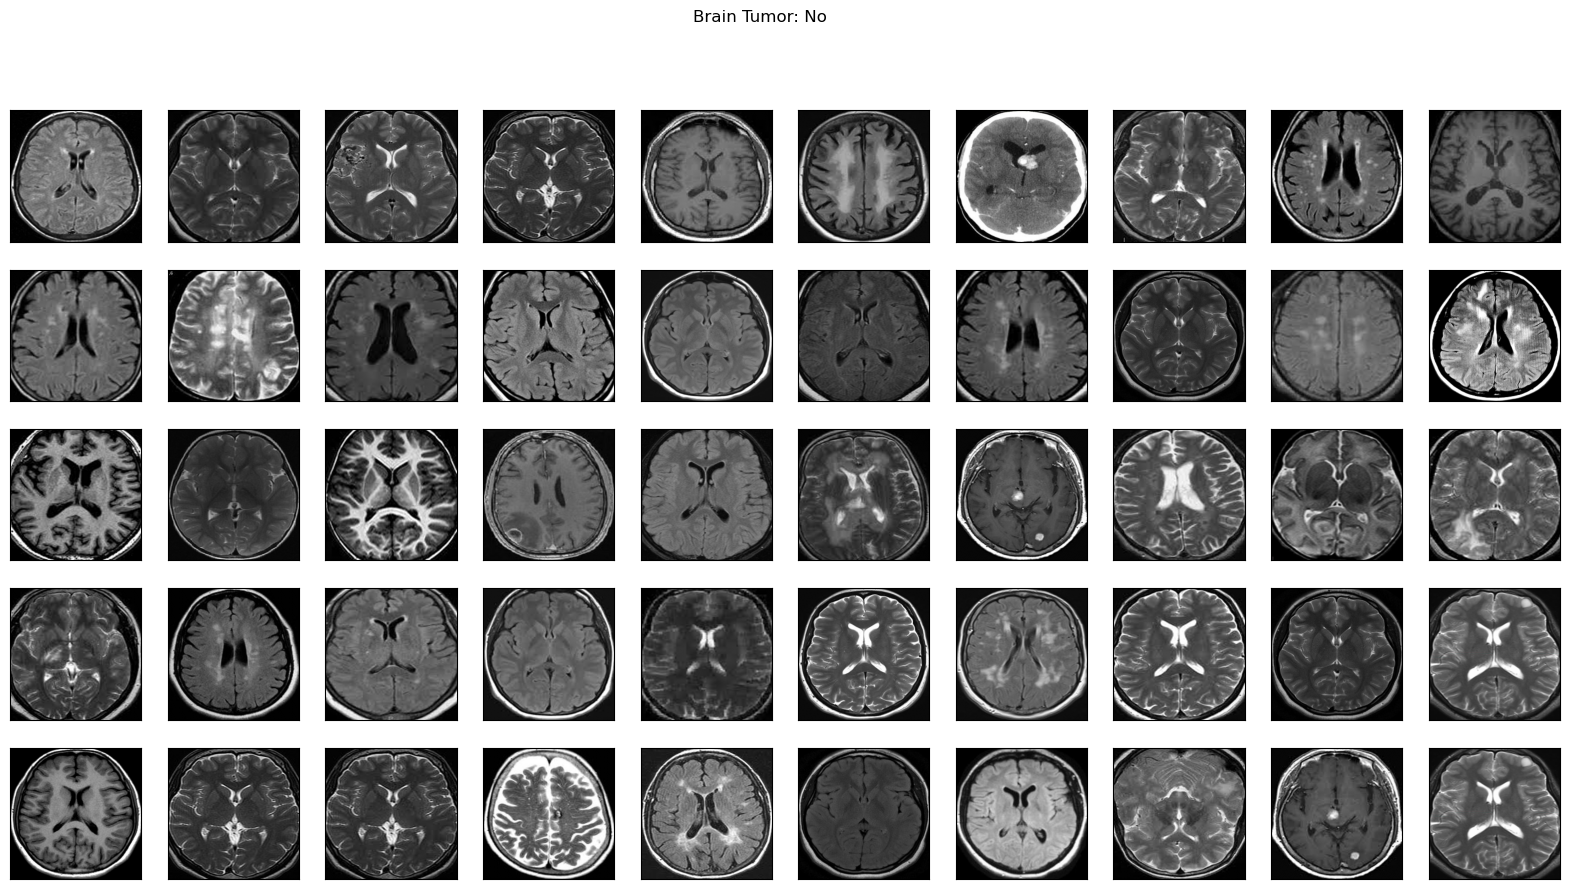

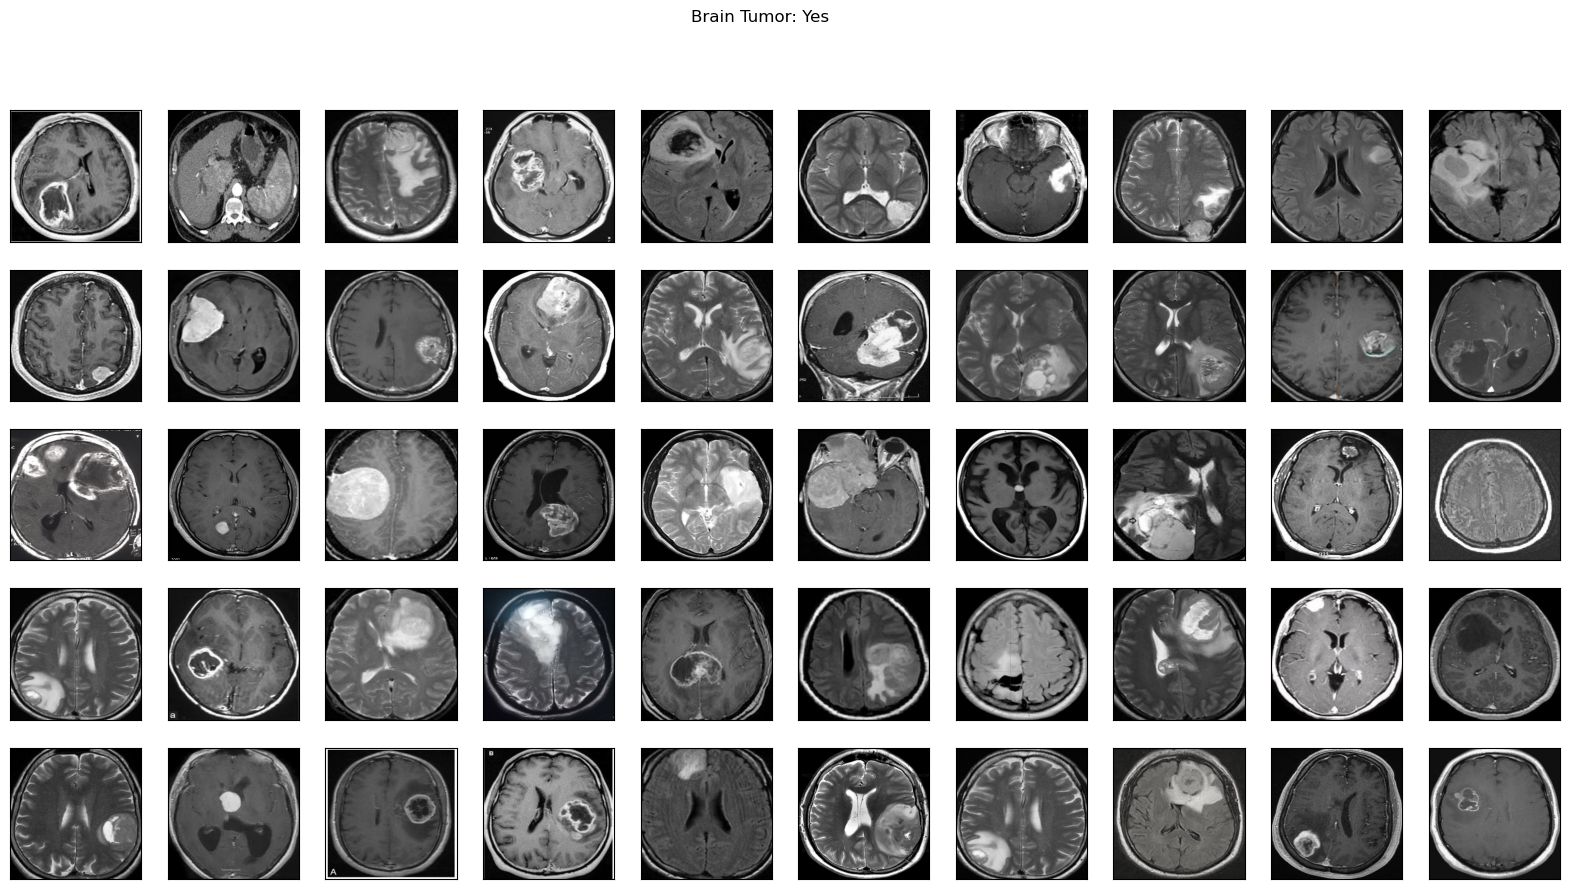

In [19]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [20]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [22]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


Some helper functions:

In [23]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [24]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

In [25]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [26]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [27]:
model = build_model(IMG_SHAPE)

In [28]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [29]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [31]:
from keras.callbacks import ModelCheckpoint

filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [32]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)


## Train the model

In [33]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5966 - loss: 1.5631
Epoch 1: val_accuracy improved from -inf to 0.55263, saving model to models/cnn-parameters-improvement-01-0.55.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5913 - loss: 1.5907 - val_accuracy: 0.5526 - val_loss: 0.7599
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5034 - loss: 1.1331
Epoch 2: val_accuracy did not improve from 0.55263
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4977 - loss: 1.1299 - val_accuracy: 0.5526 - val_loss: 0.7270
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7042 - loss: 0.6764
Epoch 3: val_accuracy did not improve from 0.55263
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7069 - loss: 0.6754 - val_accuracy: 0.5526 - val_loss: 0.7474
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7610 - loss: 0.5519
Epoch 4: val_accuracy did not improve from 0.55263
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7612 - loss: 0.5

Let's train for a few more epochs:

In [34]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9222 - loss: 0.2729
Epoch 1: val_accuracy improved from 0.65789 to 0.71053, saving model to models/cnn-parameters-improvement-01-0.71.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9244 - loss: 0.2712 - val_accuracy: 0.7105 - val_loss: 0.6132
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9158 - loss: 0.2425
Epoch 2: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9149 - loss: 0.2433 - val_accuracy: 0.6579 - val_loss: 0.6066
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9434 - loss: 0.2401
Epoch 3: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9418 - loss: 0.2393 - val_accuracy: 0.7105 - val_loss: 0.6074
Elapsed time: 0:0:41.3


In [35]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9381 - loss: 0.2176
Epoch 1: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9373 - loss: 0.2183 - val_accuracy: 0.6579 - val_loss: 0.5937
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9516 - loss: 0.2074
Epoch 2: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9520 - loss: 0.2066 - val_accuracy: 0.6842 - val_loss: 0.5921
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9380 - loss: 0.2065
Epoch 3: val_accuracy did not improve from 0.71053
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9388 - loss: 0.2053 - val_accuracy: 0.7105 - val_loss: 0.5846
Elapsed time: 0:0:37.9


In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9719 - loss: 0.1743
Epoch 1: val_accuracy improved from 0.71053 to 0.73684, saving model to models/cnn-parameters-improvement-01-0.74.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9687 - loss: 0.1772 - val_accuracy: 0.7368 - val_loss: 0.5798
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9285 - loss: 0.2102
Epoch 2: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9315 - loss: 0.2084 - val_accuracy: 0.7368 - val_loss: 0.5757
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9449 - loss: 0.1888
Epoch 3: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9471 - loss: 0.1860 - val_accuracy: 0.6579 - val_loss: 0.5689
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9688 - loss: 0.1531
Epoch 4: val_accuracy did not improve from 0.73684
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9692 - loss: 0.15

In [37]:
history = model.history.history

In [38]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [39]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']  # Change 'acc' to 'accuracy'
    val_acc = history['val_accuracy']  # Change 'val_acc' to 'val_accuracy'
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

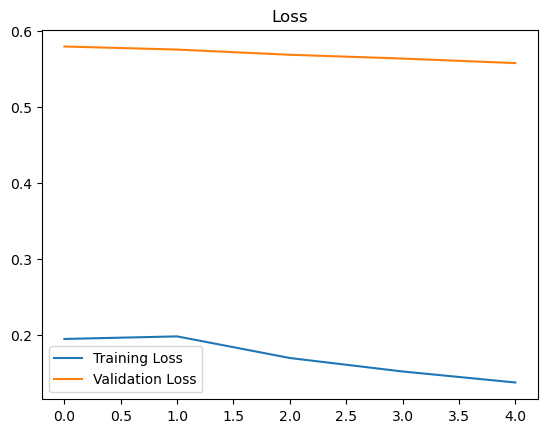

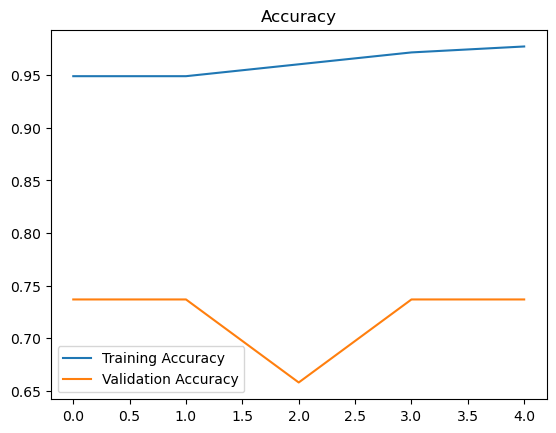

In [43]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

### Load the best model

In [44]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)


Keras version: 3.6.0
TensorFlow version: 2.18.0


In [64]:
!pip install keras==2.11 tensorflow==2.11


ERROR: Could not find a version that satisfies the requirement tensorflow==2.11 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.11


In [67]:
import os
from keras.models import load_model

# Specify the file path

file_path = os.path.abspath('C:\\Users\\DELL\\Desktop\\streamlit ui projects\\brain tumor\\models\\cnn-parameters-improvement-08-0.61.keras')

# Check if the file exists
if os.path.exists(file_path):
    best_model = load_model(filepath=file_path)
    print("Model loaded successfully.")
else:
    print(f"Error: File not found at {file_path}")


Model loaded successfully.


In [68]:
best_model = load_model(filepath=r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\models\cnn-parameters-improvement-08-0.61.keras')


In [69]:
from keras.models import load_model
from keras.models import load_model

#best_model = load_model(filepath=r'C:\Users\91994\Downloads\Brain-Tumor-Detection-master\Brain-Tumor-Detection-master\models\cnn-parameters-improvement-23-0.91.model)
best_model = load_model(filepath=r'C:\Users\DELL\Desktop\streamlit ui projects\brain tumor\models\cnn-parameters-improvement-08-0.61.keras')


In [70]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [71]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.6014 - loss: 0.6312


### Accuracy of the best model on the testing data:

In [72]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.6341888308525085
Test Accuracy = 0.6052631735801697


### F1 score for the best model on the testing data:

In [73]:
y_test_prob = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step


In [74]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.7457627118644068


Let's also find the f1 score on the validation data:

In [75]:
y_val_prob = best_model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [76]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.7272727272727273


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [77]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [78]:
# the whole data
data_percentage(y)

Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [79]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 177
Percentage of positive examples: 63.27683615819209%, number of pos examples: 112
Percentage of negative examples: 36.72316384180791%, number of neg examples: 65
Validation Data:
Number of examples: 38
Percentage of positive examples: 55.26315789473684%, number of pos examples: 21
Percentage of negative examples: 44.73684210526316%, number of neg examples: 17
Testing Data:
Number of examples: 38
Percentage of positive examples: 57.89473684210526%, number of pos examples: 22
Percentage of negative examples: 42.10526315789474%, number of neg examples: 16


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**86.7%** accuracy on the **test set**.<br>
**0.89** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.